In [ ]:
# Imports e carregamento de dados
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

candidates = [Path('dataset') / 'dataset_corrigido.csv',
              Path('..') / 'dataset' / 'dataset_corrigido.csv',
              Path.cwd() / 'dataset' / 'dataset_corrigido.csv']
DATA_PATH = None
for p in candidates:
    if p.exists():
        DATA_PATH = p
        break
if DATA_PATH is None:
    raise FileNotFoundError('dataset_corrigido.csv not found in expected locations')

df = pd.read_csv(DATA_PATH)
print('Carregado:', DATA_PATH)
print('Shape:', df.shape)
df.head()

Carregado: ..\dataset\dataset_corrigido.csv
Shape: (156864, 9)


,ano,id_municipio,bioma,area_total,desmatado,vegetacao_natural,nao_vegetacao_natural,hidrografia,soma_partes
0,2009,5102504,Pantanal,17422.29079,3124.8,12616.5,0.4,1680.6,14297.5
1,2011,5102504,Pantanal,17422.29079,3203.4,12537.9,0.4,1680.6,14218.9
2,2010,5102504,Pantanal,17422.29079,3157.8,12583.5,0.4,1680.6,14264.5
3,2005,5102504,Pantanal,17422.29079,2937.1,12804.2,0.4,1680.6,14485.2
4,2002,5102504,Pantanal,17422.29079,2598.0,13143.3,0.4,1680.6,14824.3


ano                        int64
id_municipio               int64
bioma                     object
area_total               float64
desmatado                float64
vegetacao_natural        float64
nao_vegetacao_natural    float64
hidrografia              float64
soma_partes              float64
dtype: object
Registros por bioma:
bioma
Mata Atlântica    73992
Cerrado           34392
Caatinga          29016
Amazônia          13416
Pampa              5520
Pantanal            528
Name: count, dtype: int64


C:\Users\samue\AppData\Local\Temp\ipykernel_25936\3156167209.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='bioma', order=df['bioma'].value_counts().index, palette='muted')


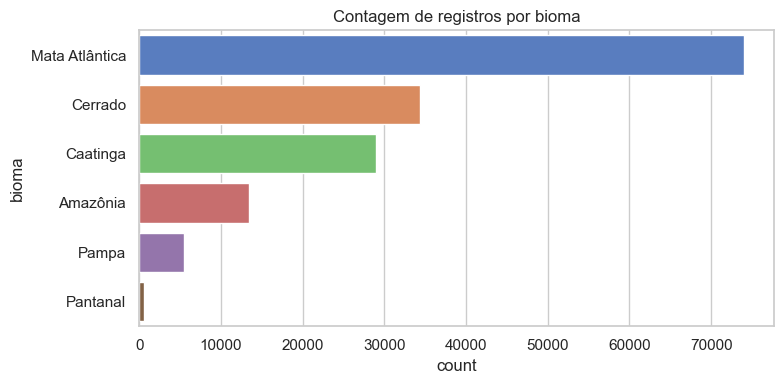

In [2]:
# Informações rápidas e contagens por bioma
print(df.dtypes)
print('Registros por bioma:')
print(df['bioma'].value_counts())

# Plot counts
plt.figure(figsize=(8,4))
sns.countplot(data=df, y='bioma', order=df['bioma'].value_counts().index, palette='muted')
plt.title('Contagem de registros por bioma')
plt.tight_layout()
plt.show()

## Distribuição de `desmatado`
O target `desmatado` apresenta alta assimetria (muitos valores baixos e alguns extremos). Vamos usar duas abordagens para visualizar corretamente: (1) clipping no percentil 99 para remover outliers extremos ao plotar; (2) transformação log(1+x) para ver a forma da distribuição sem cortar valores.

99th percentile (desmatado): 3848.60


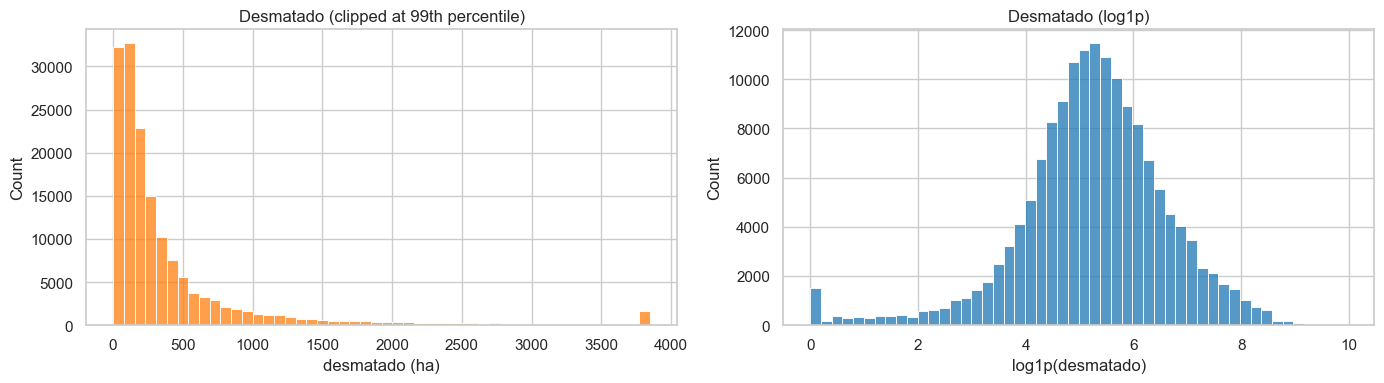

In [3]:
# Clipping e log-transform para `desmatado`
target = 'desmatado'
p99 = df[target].quantile(0.99)
print(f'99th percentile (desmatado): {p99:.2f}')
df['desmatado_clipped'] = df[target].clip(upper=p99)
df['desmatado_log1p'] = np.log1p(df[target])

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.histplot(df['desmatado_clipped'], bins=50, kde=False, color='tab:orange')
plt.title('Desmatado (clipped at 99th percentile)')
plt.xlabel('desmatado (ha)')

plt.subplot(1,2,2)
sns.histplot(df['desmatado_log1p'], bins=50, kde=False, color='tab:blue')
plt.title('Desmatado (log1p)')
plt.xlabel('log1p(desmatado)')
plt.tight_layout()
plt.show()

## Distribuição de `vegetacao_natural`
Aplicaremos o mesmo procedimento: clipping no percentil 99 e log1p para visualizar a distribuição sem distorção por poucos valores muito grandes.

99th percentile (vegetacao_natural): 11943.43


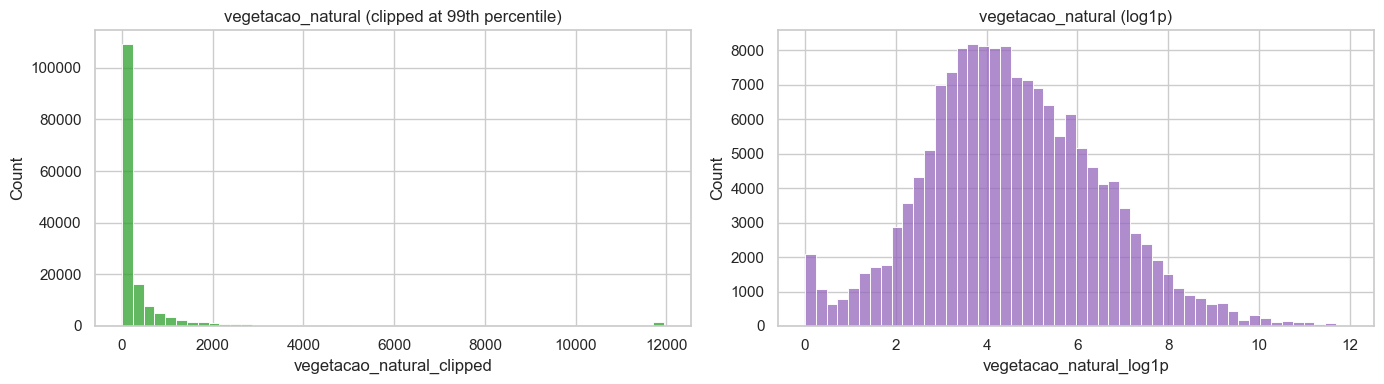

In [4]:
col = 'vegetacao_natural'
p99_v = df[col].quantile(0.99)
print(f'99th percentile ({col}): {p99_v:.2f}')
df[col + '_clipped'] = df[col].clip(upper=p99_v)
df[col + '_log1p'] = np.log1p(df[col])

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.histplot(df[col + '_clipped'], bins=50, color='tab:green')
plt.title(f'{col} (clipped at 99th percentile)')

plt.subplot(1,2,2)
sns.histplot(df[col + '_log1p'], bins=50, color='tab:purple')
plt.title(f'{col} (log1p)')
plt.tight_layout()
plt.show()

## Boxplot de `desmatado` por `bioma` (usando log)
Boxplots com escala linear seriam dominados por outliers; usaremos log1p para visualizar a diferença entre biomas.

C:\Users\samue\AppData\Local\Temp\ipykernel_25936\2762035781.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='desmatado_log1p', y='bioma', order=order, palette='viridis')


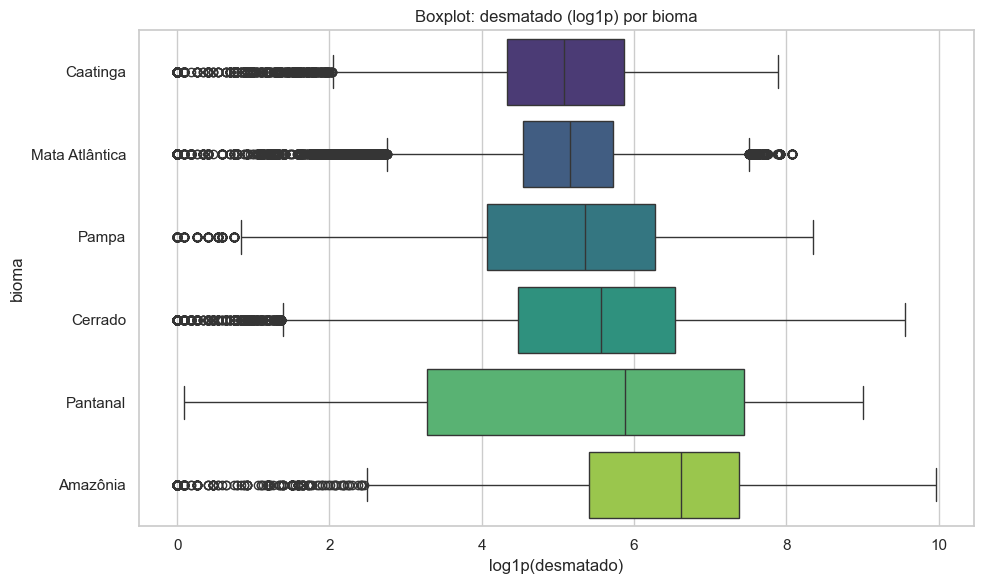

In [5]:
plt.figure(figsize=(10,6))
# ordena biomas por mediana de desmatado
order = df.groupby('bioma')['desmatado'].median().sort_values().index
sns.boxplot(data=df, x='desmatado_log1p', y='bioma', order=order, palette='viridis')
plt.xlabel('log1p(desmatado)')
plt.title('Boxplot: desmatado (log1p) por bioma')
plt.tight_layout()
plt.show()

## Série temporal: média anual de `desmatado` (geral e por bioma)
Vamos ver a tendência ao longo dos anos. Para visualização, traçamos a média anual e, para evitar distorção por outliers, também mostramos a versão log1p.

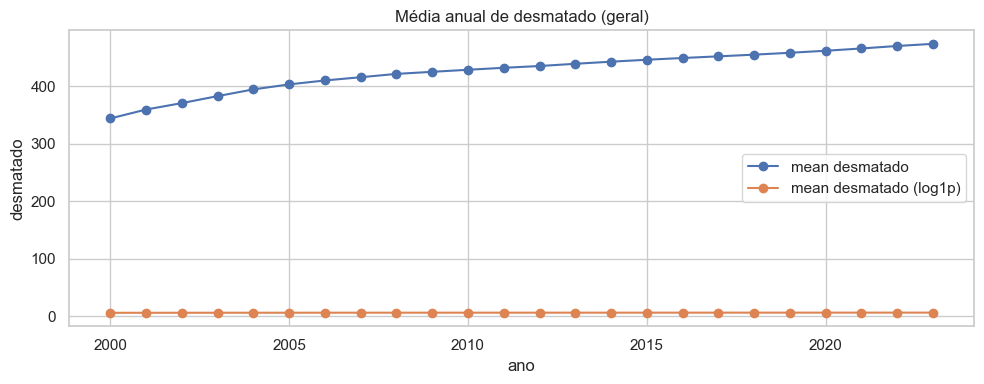

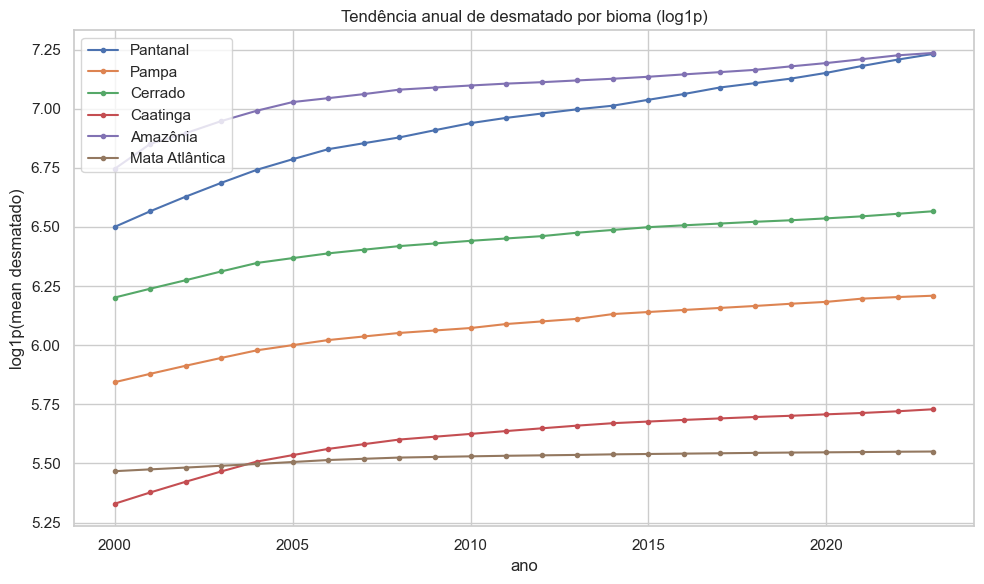

In [6]:
df_year = df.groupby('ano')['desmatado'].mean().reset_index()
df_year['desmatado_log1p'] = np.log1p(df_year['desmatado'])
plt.figure(figsize=(10,4))
plt.plot(df_year['ano'], df_year['desmatado'], marker='o', label='mean desmatado')
plt.plot(df_year['ano'], df_year['desmatado_log1p'], marker='o', label='mean desmatado (log1p)')
plt.xlabel('ano')
plt.ylabel('desmatado')
plt.title('Média anual de desmatado (geral)')
plt.legend()
plt.tight_layout()
plt.show()

# Por bioma (apenas alguns biomas para evitar poluição visual)
plt.figure(figsize=(10,6))
for b in df['bioma'].unique():
    d = df[df['bioma'] == b].groupby('ano')['desmatado'].mean().reset_index()
    plt.plot(d['ano'], np.log1p(d['desmatado']), marker='.', label=b)
plt.xlabel('ano')
plt.ylabel('log1p(mean desmatado)')
plt.title('Tendência anual de desmatado por bioma (log1p)')
plt.legend()
plt.tight_layout()
plt.show()

## Correlação entre `desmatado_prev` e `desmatado`
Como vimos anteriormente, a variável `desmatado_prev` (desmatamento do ano anterior no mesmo município) é muito informativa. Vamos gerar essa variável e visualizar a relação.

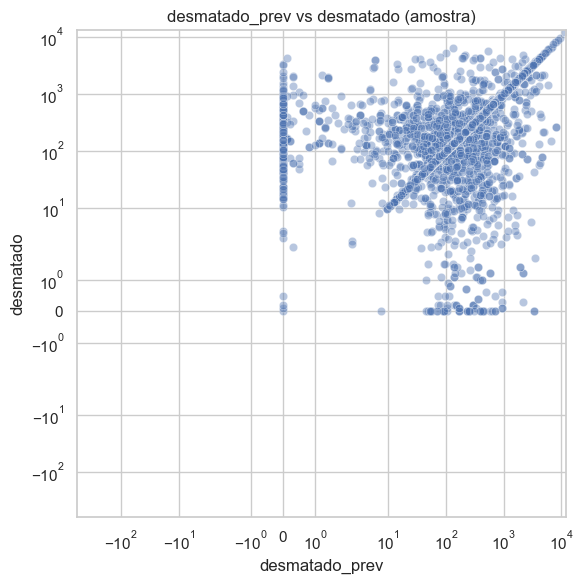

Correlação (pearson): 0.7580066783783146


In [7]:
# criar desmatado_prev por município
df_sorted = df.sort_values(['id_municipio', 'ano']).copy()
df_sorted['desmatado_prev'] = df_sorted.groupby('id_municipio')['desmatado'].shift(1).fillna(0)
# amostra para plot (para não sobrecarregar)
sample = df_sorted.sample(n=5000, random_state=42)
plt.figure(figsize=(6,6))
sns.scatterplot(x=sample['desmatado_prev'], y=sample['desmatado'], alpha=0.4)
plt.xscale('symlog')
plt.yscale('symlog')
plt.xlabel('desmatado_prev')
plt.ylabel('desmatado')
plt.title('desmatado_prev vs desmatado (amostra)')
plt.tight_layout()
plt.show()

print('Correlação (pearson):', sample['desmatado_prev'].corr(sample['desmatado']))

## Conclusões rápidas
- A variável `desmatado` é altamente assimétrica; usar clipping (99th percentile) e transformação `log1p` ajuda a visualizar a distribuição sem perder informação.
- `desmatado_prev` tem forte correlação com `desmatado` — útil mas recomenda-se avaliar modelos sem essa feature para entender ganhos reais.
